In [202]:
from bs4 import BeautifulSoup
import requests
from pprint import pprint
from collections import defaultdict
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, cross_val_score, cross_val_predict
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


%matplotlib inline

Scrape boxofficemojo.com for movie information using BeautifulSoup.

In [203]:


base_url = 'http://www.boxofficemojo.com/movies/?id='
slug = 'room2015.htm'

url = 'http://www.boxofficemojo.com/genres/'

def get_soup_object(html):
    response = requests.get(html)
    raw_html = response.text
    return BeautifulSoup(raw_html)

soup = get_soup_object(url)

# print soup.prettify()

Scrape the website's genre list to get the genre_name, genre_url, genre_gross and number of movies in that genre.

In [204]:
all_tables = soup.find_all('table')
rows_with_stuff = all_tables[2].find('tr').find_all('tr')


def get_genre_dict(rows_with_stuff):
    genre_dict = {}
    for row_soup in rows_with_stuff:
        cells = row_soup.find_all('td')
        genre, num_movies, top_picture, gross = [c for c in cells]
        genre_name = genre.text
        genre_url = genre.find('a')['href']
        genre_dict[genre_name] = ([genre_url, gross, num_movies])
    return genre_dict
    
genre_dict = get_genre_dict(rows_with_stuff)
del(genre_dict['Genre (click to view chart)'])
print len(genre_dict), genre_dict

212 {u'Horse': ['./chart/?id=horse.htm', <td align="right"><font size="2">$120.3</font></td>, <td align="right"><font size="2">31</font></td>], u'Sports - Boxing': ['./chart/?id=boxing.htm', <td align="right"><font size="2">$127.9</font></td>, <td align="right"><font size="2">48</font></td>], u'Romantic Fantasy': ['./chart/?id=romanticfantasy.htm', <td align="right"><font size="2">$300.5</font></td>, <td align="right"><font size="2">51</font></td>], u'Thriller - Psycho / Stalker / Blank from Hell': ['./chart/?id=psychothriller.htm', <td align="right"><font size="2">$156.6</font></td>, <td align="right"><font size="2">38</font></td>], u'Comedy - Fat Suit': ['./chart/?id=fatsuit.htm', <td align="right"><font size="2">$219.2</font></td>, <td align="right"><font size="2">26</font></td>], u'Documentary - Nature': ['./chart/?id=naturedoc.htm', <td align="right"><font size="2">$77.4</font></td>, <td align="right"><font size="2">30</font></td>], u'Travelogue - New Orleans': ['./chart/?id=newor

In [205]:
# Gets the genre url and calls the BeautifulSoup (get_soup_object) function to get the movie information for each genre

movie_dict = defaultdict(list)
def get_movie_dict(rows_with_genre_movies, genre):
#     print "in def2"
    for row_genre in rows_with_genre_movies[1:]:
        cells = row_genre.find_all('td')
        if len(cells) == 8:
            rank, title, studio, lifetime_gross, lifetime_theatres, opening_weekend_gross, opening_theatres, date = [cell for cell in cells]
            movie_url = title.find('a')['href']
            movie_dict[title.text].append([genre, rank.text, movie_url, studio.text, lifetime_gross.text, lifetime_theatres.text, opening_weekend_gross.text, opening_theatres.text])


base_url = 'http://www.boxofficemojo.com/genres'

def get_movieslist_for_genre(genre_dict):
    extention_url = genre_dict[1][0]
    genre_url = base_url+(extention_url.lstrip('.'))
    genre_object = get_soup_object(genre_url)
    genre_movie_tables = genre_object.find_all('table')
    rows_with_genre_movies = genre_movie_tables[2].find('tr').find_all('tr')
    genre = genre_dict[0]
    get_movie_dict(rows_with_genre_movies, genre)

for item in genre_dict.items():
    get_movieslist_for_genre(item)
    
# movies
print len(movie_dict), movie_dict.items()[100]

6060 (u'Behind the Mask: The Rise of Leslie Vernon', [[u'Horror Comedy', u'91', '/movies/?id=behindthemask.htm', u'Anch.', u'$69,136', u'72', u'$38,500', u'72'], [u'Horror - Slasher', u'95', '/movies/?id=behindthemask.htm', u'Anch.', u'$69,136', u'72', u'$38,500', u'72']])


In [6]:
# movie_dict.items()[200]

Some of the movies are listed under multiple genres and to copy them into a pandas dataframe I just kept the first one and deleted the rest.

In [206]:
movie_dict1 = {}
def get_single_value_per_movie(movie_dict):
    for key, values in movie_dict.iteritems():
        if len(values) >= 1:
            movie_dict1[key] = values[0]
    return movie_dict1

movie_dict1 = get_single_value_per_movie(movie_dict)
# movie_dict1.items()[0]

## Pickle movie_dict dictionary as movie_dict.pkl

In [209]:
import pickle

with open('movie_dict.pkl', 'w') as picklefile:
    pickle.dump(movie_dict1, picklefile)

In [210]:
# Import pickled data and
# Convert the movie data dictionary (movie_dict1) into a pandas dataframe

import pandas as pd

cols = ['Genre', 'Rank', 'Movie_url', 'Studio', 'Lifetime_gross', 'Lifetime-theatres', 'OpeningWeekend_gross', 'openingWeekend_theatres']
with open('movie_dict.pkl', 'r') as picklefile:
    movie_data = pickle.load(picklefile)
    df = pd.DataFrame.from_dict(movie_data, orient='index')
    df.columns = cols
df.head()



,Genre,Rank,Movie_url,Studio,Lifetime_gross,Lifetime-theatres,OpeningWeekend_gross,openingWeekend_theatres
Elephant(2003),Cannes Film Festival - Palme D'Or winners,23,/movies/?id=elephant.htm,FL,"$1,266,955",38,"$93,356",6
Vampires Suck,Horror Comedy,17,/movies/?id=untitledvampirespoof.htm,Fox,"$36,661,504","3,233","$12,202,831","3,233"
The Road,Post-Apocalypse,32,/movies/?id=road08.htm,W/Dim.,"$8,117,000",396,"$1,502,231",111
Rob Roy,Adventure - Period,47,/movies/?id=robroy.htm,MGM,"$31,596,911","1,885","$2,023,272",133
Sugar,Sports Drama,100,/movies/?id=sugar09.htm,SPC,"$1,082,124",51,"$60,140",11


Clean the data by first getting rid of '$' and','. Then replace all the 'n/a's with numpy nan's and drop all the rows with na values for 'Lifetime_gross' and 'OpeningWeekend_gross' columns. 

In [9]:
df['Lifetime_gross'] = df['Lifetime_gross'].str.lstrip('$').str.replace(',','')
df['OpeningWeekend_gross'] = df['OpeningWeekend_gross'].str.lstrip('$').str.replace(',','')
df['openingWeekend_theatres'] = df['openingWeekend_theatres'].str.replace(',','')

df.head()


,Genre,Rank,Movie_url,Studio,Lifetime_gross,Lifetime-theatres,OpeningWeekend_gross,openingWeekend_theatres
Elephant(2003),Cannes Film Festival - Palme D'Or winners,23,/movies/?id=elephant.htm,FL,1266955,38,93356,6
Vampires Suck,Horror Comedy,17,/movies/?id=untitledvampirespoof.htm,Fox,36661504,"3,233",12202831,3233
The Road,Post-Apocalypse,32,/movies/?id=road08.htm,W/Dim.,8117000,396,1502231,111
Rob Roy,Adventure - Period,47,/movies/?id=robroy.htm,MGM,31596911,"1,885",2023272,133
Sugar,Sports Drama,100,/movies/?id=sugar09.htm,SPC,1082124,51,60140,11


In [10]:
import numpy as np

df = df.replace('n/a', np.nan)
df = df.dropna(subset=['Lifetime_gross'])
df = df.dropna(subset=['OpeningWeekend_gross'])
df = df.dropna(subset=['openingWeekend_theatres'])
df.dtypes
df['title'] = df.index

f = lambda x: float(x) 
df['Lifetime_gross'] = df['Lifetime_gross'].apply(f)
df['OpeningWeekend_gross'] = df['OpeningWeekend_gross'].apply(f)
df['openingWeekend_theatres'] = df['openingWeekend_theatres'].apply(f)

df.dtypes

Genre                       object
Rank                        object
Movie_url                   object
Studio                      object
Lifetime_gross             float64
Lifetime-theatres           object
OpeningWeekend_gross       float64
openingWeekend_theatres    float64
title                       object
dtype: object

In [11]:
movie_df = df[['title', 'Lifetime_gross', 'OpeningWeekend_gross', 'openingWeekend_theatres']]
movie_df.shape

(5711, 4)

Read movie reviews data from metacritic_movies.json file and read into a pandas dataframe.

In [12]:
metafile = 'metacritic_movies.json'
meta_df = pd.read_json(metafile).T
meta_df.columns
meta_df.head()

,complete,director,genre,metacritic_page,metascore,num_critic_reviews,num_user_ratings,num_user_reviews,rating,release_date,runtime_minutes,studio,title,user_score,year
100030,True,Elio Petri,"[Drama, Crime]",/movie/investigation-of-a-citizen-above-suspic...,89,"[10, 0, 0, 10]",8,"[3, 0, 0, 3]",R,2003-04-04,112,Columbia Pictures,Investigation of a Citizen Above Suspicion [re...,8,2003
10007,False,Isaac Florentine,"[Action, Thriller, Crime]",/movie/ninja-shadow-of-a-tear,None,"[1, 0, 0, 1]",6,"[1, 1, 0, 2]",R,2013-12-31,95,Millennium Entertainment,Ninja: Shadow of a Tear,7.7,2013
100087,True,Lawrence Kasdan,"[Drama, Thriller, Crime]",/movie/body-heat,78,"[8, 2, 0, 10]",31,"[5, 0, 1, 6]",R,1981-08-28,113,Warner Bros. Pictures,Body Heat,8.8,1981
100128,False,Nikolaus Geyrhalter,[Documentary],/movie/our-daily-bread,86,"[10, 0, 0, 10]",13,"[2, 0, 0, 2]",,2006-11-24,92,None,Our Daily Bread,7.7,2006
10014,False,Michael Taverna,[Horror],/movie/apartment-1303-3d,None,"[0, 0, 1, 1]",6,"[0, 0, 2, 2]",R,2013-07-25,85,Gravitas Ventures,Apartment 1303 3D,2.2,2013


In [13]:
good_columns = ([u'title', u'num_critic_reviews', u'metascore'])
reviews_df = meta_df[good_columns]
reviews_df.shape

(4438, 3)

lightly_processed_title is a function that takes a string and removes blank spaces, converts all the letters into lower case.

We apply this function to the titles column of both movie_df and reviews_df. Then, we merge these two data frames on title.

In [14]:
def lightly_processed_title(title):
    title = title.replace(' ','').lower()
    charlist = list(title)
    charlist = [char for char in charlist if char.isalnum()]
    return ''.join(charlist)

movie_df.loc[:,'title'] = movie_df.loc[:,'title'].apply(lightly_processed_title)
reviews_df.loc[:,'title'] = reviews_df.loc[:,'title'].apply(lightly_processed_title)

regression_df = pd.merge(movie_df, reviews_df, on='title', how='inner')
regression_df.shape

//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:420: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(2317, 6)

Critics reviews column in regression_df (num_critics_reviews) is a list of 4 values and I used replace and split functions on this column to store each value in a different column. 


The 4 new columns are:
critics_positive
critics_neutral
critics_negative
critics_total_reviews

In [15]:
regression_df['num_critic_reviews'] = regression_df['num_critic_reviews'].apply(lambda x: str(x))
regression_df['critics_positive'] = regression_df['num_critic_reviews'].apply(lambda x: x.replace('[','').split(',')[0])
regression_df['critics_neutral'] = regression_df['num_critic_reviews'].apply(lambda x: x.split(',')[1])
regression_df['critics_negative'] = regression_df['num_critic_reviews'].apply(lambda x: x.split(',')[2])
regression_df['critics_total_reviews'] = regression_df['num_critic_reviews'].apply(lambda x: x.replace(']','').split(',')[3])
regression_df.dtypes

regression_df['critics_positive'] = regression_df['critics_positive'].apply(lambda x: int(x))
regression_df['critics_neutral'] = regression_df['critics_neutral'].apply(lambda x: int(x))
regression_df['critics_negative'] = regression_df['critics_negative'].apply(lambda x: int(x))
regression_df['critics_total_reviews'] = regression_df['critics_total_reviews'].apply(lambda x: int(x))
regression_df.head(10)

,title,Lifetime_gross,OpeningWeekend_gross,openingWeekend_theatres,num_critic_reviews,metascore,critics_positive,critics_neutral,critics_negative,critics_total_reviews
0,theroad,8117000,1502231,111,"[26, 6, 1, 33]",64,26,6,1,33
1,theroad,8117000,1502231,111,"[7, 2, 0, 9]",71,7,2,0,9
2,thecrazies,39123589,16067552,2476,"[14, 13, 3, 30]",55,14,13,3,30
3,blade,70087718,17073856,2322,"[8, 7, 8, 23]",45,8,7,8,23
4,domesticdisturbance,45246095,14033112,2910,"[4, 5, 18, 27]",29,4,5,18,27
5,paul,37412945,13043310,2802,"[21, 14, 2, 37]",57,21,14,2,37
6,supersizeme,11536423,516641,41,"[32, 4, 1, 37]",73,32,4,1,37
7,brooklynsfinest,27163593,13350299,1936,"[6, 24, 3, 33]",43,6,24,3,33
8,attacktheblock,1024175,139506,8,"[25, 1, 1, 27]",75,25,1,1,27
9,thetexaschainsawmassacre,80571655,28094014,3016,"[5, 15, 13, 33]",38,5,15,13,33


Calculated log Lifetime_gross and predicted the regression models with log_Lifetime_gross to see if it predicts a better model.

In [101]:
import math

regression_df['log_Lifetime_gross'] = regression_df['Lifetime_gross'].apply(lambda x: math.log(x))
regression_df['log_OpeningWeekend_gross'] = regression_df['OpeningWeekend_gross'].apply(lambda x: math.log(x))
regression_df['critics_positive_percentage'] = regression_df.critics_positive / regression_df.critics_total_reviews
regression_df['critics_negative_percentage'] = regression_df.critics_negative / regression_df.critics_total_reviews
regression_df['critics_neutral_percentage'] = regression_df.critics_neutral / regression_df.critics_total_reviews

regression_df = regression_df.dropna(subset=['critics_positive_percentage'])
regression_df = regression_df.dropna(subset=['critics_negative_percentage'])

regression_df.head()

,title,Lifetime_gross,OpeningWeekend_gross,openingWeekend_theatres,num_critic_reviews,metascore,critics_positive,critics_neutral,critics_negative,critics_total_reviews,log_Lifetime_gross,log_OpeningWeekend_gross,critics_positive_percentage,critics_negative_percentage,critics_neutral_percentage
0,theroad,8117000,1502231,111,"[26, 6, 1, 33]",64,26,6,1,33,15.909471,14.222462,0.787879,0.030303,0.181818
1,theroad,8117000,1502231,111,"[7, 2, 0, 9]",71,7,2,0,9,15.909471,14.222462,0.777778,0.000000,0.222222
2,thecrazies,39123589,16067552,2476,"[14, 13, 3, 30]",55,14,13,3,30,17.482236,16.592312,0.466667,0.100000,0.433333
3,blade,70087718,17073856,2322,"[8, 7, 8, 23]",45,8,7,8,23,18.065258,16.653059,0.347826,0.347826,0.304348
4,domesticdisturbance,45246095,14033112,2910,"[4, 5, 18, 27]",29,4,5,18,27,17.627627,16.456930,0.148148,0.666667,0.185185


## Model1:

Features:
    
    OpeningWeekend_gross
    
Response:

    Lifetime_gross

                            OLS Regression Results                            
Dep. Variable:         Lifetime_gross   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     5447.
Date:                Mon, 08 Feb 2016   Prob (F-statistic):               0.00
Time:                        07:27:40   Log-Likelihood:                -43854.
No. Observations:                2314   AIC:                         8.771e+04
Df Residuals:                    2312   BIC:                         8.772e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept             1.431e+07 

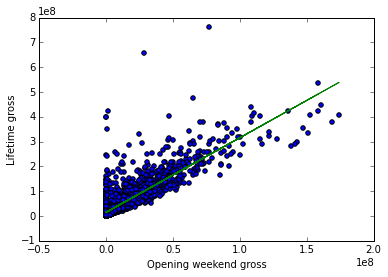

In [117]:
lm = smf.ols('Lifetime_gross ~ OpeningWeekend_gross', data=regression_df)
fit1 = lm.fit() 

print fit1.summary()

# Plot fit model with openign weekend gross as predictor
fig, ax = plt.subplots()

ax.scatter(regression_df['OpeningWeekend_gross'],regression_df['Lifetime_gross'])
ax.plot(regression_df['OpeningWeekend_gross'],fit1.predict(exog=dict(OpeningWeekend_gross = regression_df['OpeningWeekend_gross'])), color='green')

ax.set_xlabel('Opening weekend gross')
ax.set_ylabel('Lifetime gross')
plt.savefig('Fit_model_openingweekend_pred ')

## Model2:

Features:
    
    OpeningWeekend_gross
    critics_positive_percentage
    critics_negative_percentage
    critics_total_reviews

Response:
    
    Lifetime_gross
    

In [180]:
lm = smf.ols('Lifetime_gross ~ OpeningWeekend_gross + critics_positive_percentage + critics_negative_percentage + critics_total_reviews', data=regression_df)
fit2 = lm.fit()
fit2.summary()

# fig, ax = plt.subplots(nrows=1, ncols=1)
# ax.scatter(regression_df['Lifetime_gross'],fit2.resid)
# ax.annotate(' Avatar', xy=(760507625,500e6))
# ax.annotate(' Titanic', xy=(658672302,550e6))
# ax.set_xlabel('Actual Value (millions)')
# ax.set_ylabel('Residuals')
# ax.set_title('Actual Lifeitme gross vs Residuals')

# ax.axhline(y=0, xmin=0, xmax=10)
# plt.savefig("Actual_lifetime_gross(openingWeekend)_vs_residuals")

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Lifetime_gross   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1515.
Date:                Mon, 08 Feb 2016   Prob (F-statistic):               0.00
Time:                        11:12:04   Log-Likelihood:                -43765.
No. Observations:                2314   AIC:                         8.754e+04
Df Residuals:                    2309   BIC:                         8.757e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                    1.043e+06   3.96e+06      0.263      0.792     -6.72e+06  8.81e+06
OpeningWeekend_gross            3.0839      0.042     72.921      0.000         3.001     3.167
critics_positive_percentage  4.086e+07   4.44e+06      9.208      0.000      3.22e+07  4.96e+07
critics_negative_percentage   3.88e+06   6.21e+06      0.625      0.532      -8.3e+06  1.61e+07
critics_total_reviews       -3.138e+05   9.26e+04     -3.388      0.001     -4.95e+05 -1.32e+05
==============================================================================
Omnibus:                     2329.447   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           199743.172
Skew:                           4.706   Prob(JB):                         0.00
Kurtosis:                      47.532   Cond. No.                     2.50e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Model3:

Features:
    
    log_OpeningWeekend_gross
    critics_positive_percentage
    critics_negative_percentage
    critics_total_reviews
    
Response:
    
    log_Lifetime_gross

                            OLS Regression Results                            
Dep. Variable:     log_Lifetime_gross   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     2459.
Date:                Mon, 08 Feb 2016   Prob (F-statistic):               0.00
Time:                        13:17:48   Log-Likelihood:                -3223.4
No. Observations:                2314   AIC:                             6457.
Df Residuals:                    2309   BIC:                             6486.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept         

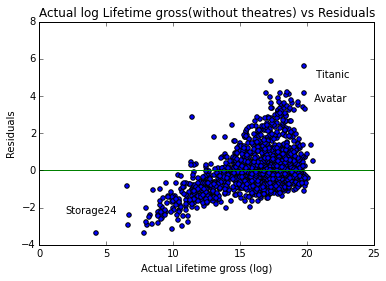

In [200]:
lm = smf.ols('log_Lifetime_gross ~ log_OpeningWeekend_gross + critics_positive_percentage + critics_negative_percentage + critics_total_reviews', data=regression_df)
fit3 = lm.fit()
print fit3.summary()

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(regression_df['log_Lifetime_gross'],fit3.resid)
ax.annotate(' Avatar', xy=(20.305737,3.7))
ax.annotate(' Titanic', xy=(20.44,5))
ax.annotate('Storage24', xy=(2, -2.3))
ax.set_xlabel('Actual Lifetime gross (log)')
ax.set_ylabel('Residuals')
ax.set_title('Actual log Lifetime gross(without theatres) vs Residuals')

ax.axhline(y=0, xmin=0, xmax=10, color='green')
plt.savefig('Actual_log_Lifetime_(openingWeekend_and_critics)_vs_Residuals')

## Model 4:

Features:
    
    log_OpeningWeekend_gross
    openingWeekend_theatres
    critics_positive_percentage
    critics_negative_percentage
    critics_total_reviews
    
Response:

    log_Lifetime_gross

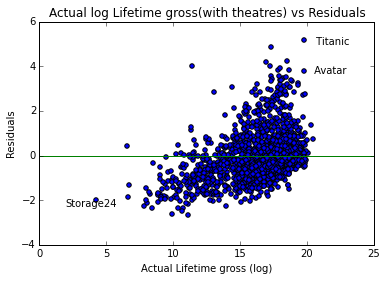

In [201]:
lm = smf.ols('log_Lifetime_gross ~ log_OpeningWeekend_gross + critics_positive_percentage + critics_negative_percentage + critics_total_reviews+ openingWeekend_theatres', data=regression_df)
fit4 = lm.fit()
# print fit4.summary()

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.scatter(regression_df['log_Lifetime_gross'],fit4.resid)
ax.annotate(' Avatar', xy=(20.305737,3.7))
ax.annotate(' Titanic', xy=(20.44,5))
ax.annotate('Storage24', xy=(2, -2.3))
ax.set_xlabel('Actual Lifetime gross (log)')
ax.set_ylabel('Residuals')
ax.set_title('Actual log Lifetime gross(with theatres) vs Residuals')

ax.axhline(y=0, xmin=0, xmax=10, color='green')

plt.savefig('Actual_log_Lifetime_(openingWeekend_critics_openingTheatres)_vs_Residuals')

StandardScaler is a sklearn module used to normalize values by removing the mean and scaling to unit variance. It returns a numpy array of normalized values.

In [111]:
# print regression_df.shape
# px2 = StandardScaler().fit_transform(regression_df[['Lifetime_gross','OpeningWeekend_gross']])

# regression_norm_df = pd.DataFrame({'Lifetime_gross':px2[:,0],'OpeningWeekend_gross':px2[:,1]})
# regression_norm_df['title'] = regression_df['title']
# regression_norm_df['critics_positive_percentage'] = regression_df['critics_positive_percentage']
# regression_norm_df['critics_negative_percentage'] = regression_df['critics_negative_percentage']
# regression_norm_df['critics_total_reviews'] = regression_df['critics_total_reviews']
# regression_norm_df.shape
# regression_norm_df.head()

(2314, 15)


,Lifetime_gross,OpeningWeekend_gross,title,critics_positive_percentage,critics_negative_percentage,critics_total_reviews
0,-0.692625,-0.657026,theroad,0.787879,0.030303,33
1,-0.692625,-0.657026,theroad,0.777778,0.000000,9
2,-0.281291,0.037581,thecrazies,0.466667,0.100000,30
3,0.129480,0.085571,blade,0.347826,0.347826,23
4,-0.200070,-0.059440,domesticdisturbance,0.148148,0.666667,27


## Model 5:
Linear regression model on normalized data with 4 featres:

Features:
1. OpeningWeekend_gross
2. critics_positive
3. critics_neutral
4. critics_negative

Response:
Lifetime_gross

In [178]:
lm2 = smf.ols('Lifetime_gross ~ OpeningWeekend_gross + critics_positive_percentage +  critics_negative_percentage + critics_total_reviews', data=regression_norm_df)

fit5 = lm2.fit()
fit5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Lifetime_gross   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     1361.
Date:                Mon, 08 Feb 2016   Prob (F-statistic):               0.00
Time:                        09:13:28   Log-Likelihood:                -1879.7
No. Observations:                2311   AIC:                             3769.
Df Residuals:                    2306   BIC:                             3798.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.0204      0.055     -0.374      0.708        -0.128     0.087
OpeningWeekend_gross            0.8378      0.011     73.757      0.000         0.816     0.860
critics_positive_percentage    -0.0591      0.061     -0.975      0.330        -0.178     0.060
critics_negative_percentage    -0.0074      0.085     -0.086      0.931        -0.175     0.160
critics_total_reviews           0.0019      0.001      1.555      0.120        -0.000     0.004
==============================================================================
Omnibus:                     2309.423   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           175909.685
Skew:                           4.697   Prob(JB):                         0.00
Kurtosis:                      44.697   Cond. No.                         280.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
lm = smf.ols('Lifetime_gross ~ openingWeekend_theatres', data=regression_df)
fit6 = lm.fit()
fit6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Lifetime_gross   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     942.2
Date:                Mon, 08 Feb 2016   Prob (F-statistic):          7.58e-174
Time:                        11:54:45   Log-Likelihood:                -44859.
No. Observations:                2314   AIC:                         8.972e+04
Df Residuals:                    2312   BIC:                         8.973e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                6.187e+06    2.2e+06      2.807      0.005      1.86e+06  1.05e+07
openingWeekend_theatres   2.95e+04    961.049     30.695      0.000      2.76e+04  3.14e+04
==============================================================================
Omnibus:                     1500.017   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22682.267
Skew:                           2.849   Prob(JB):                         0.00
Kurtosis:                      17.240   Cond. No.                     3.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
regression['critics_neutral_percentage'] = 1-(regression['critics_positive_percentage']+regression['critics_negative_percentage'])

lm1 = smf.ols('Lifetime_gross ~ OpeningWeekend_gross + critics_positive_percentage + critics_neutral_percentage+critics_total_reviews ', data=regression)
fit4 = lm1.fit()
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Lifetime_gross   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     1515.
Date:                Sun, 07 Feb 2016   Prob (F-statistic):               0.00
Time:                        16:08:20   Log-Likelihood:                -1794.0
No. Observations:                2314   AIC:                             3598.
Df Residuals:                    2309   BIC:                             3627.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      -0.1097      0.055     -1.996      0.046        -0.217    -0.002
OpeningWeekend_gross            0.8578      0.012     72.921      0.000         0.835     0.881
critics_positive_percentage     0.4907      0.053      9.235      0.000         0.386     0.595
critics_neutral_percentage     -0.0515      0.082     -0.625      0.532        -0.213     0.110
critics_total_reviews          -0.0042      0.001     -3.388      0.001        -0.007    -0.002
==============================================================================
Omnibus:                     2329.447   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           199743.172
Skew:                           4.706   Prob(JB):                         0.00
Kurtosis:                      47.532   Cond. No.                         274.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

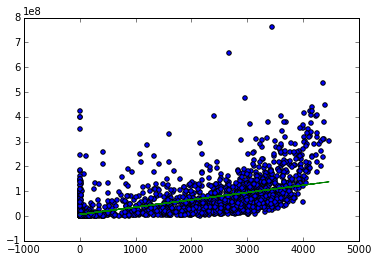

In [184]:
# Plot of the fit model with opening weekend theatres as predictor and lifetime gross as response
# print Xypreds = fit9.predict()

fig, ax = plt.subplots()

ax.scatter(regression_df['openingWeekend_theatres'], regression_df['Lifetime_gross'])
ax.plot(regression_df['openingWeekend_theatres'],fit6.predict(exog=dict(openingWeekend_theatres = regression_df['openingWeekend_theatres'])), color='green')

plt.show()

Canculate the train test set scores, cross validation score and Ridge regression score.

In [181]:
# Train-test regression score, crossvalidation score and ridge regression score
# for the final model i.e., Opening weekend gross and opening weekend theatres as predictors
lr = LinearRegression()
X = regression_df[['critics_positive_percentage', 'critics_negative_percentage', 'critics_total_reviews', 'log_OpeningWeekend_gross', 'openingWeekend_theatres']]
y = regression_df['log_Lifetime_gross']


lr.fit(X, y)
lr.score(X,y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print X_train.shape, y_train.shape, X_test.shape, y_test.shape
# Fit the model against the training data
lr.fit(X_train, y_train)
# Evaluate the model against the testing data
print 'Score = ', lr.score(X_test, y_test)

predictions_score = cross_val_score(lr, X_train, y_train, cv=10)
score = np.average(predictions_score)
print score


rcv = RidgeCV(cv=10)
rcv.fit(X, y)
rcv.score(X_test, y_test)

(1619, 5) (1619,) (695, 5) (695,)
Score =  0.825600057581
0.823125679449


0.82606305036823191